### Scenarios:
1. Single file -> Single word cloud
2. Multiple files -> Single word cloud
3. Multiple files -> Multiple word clouds + Combined word cloud

### Limitations:
* Text in images cannot be read. Here is a [workaround](https://www.thewindowsclub.com/extract-text-from-an-image-in-word) to extract text from images.
* Scanned PDFs (You know a PDF was scanned if you can't select text with your mouse when you open it normally)
    * SOTA OCR methods are still not perfect
    * Takes longer to run

---

Install necessary libraries:  
* PDF Plumber
* NLTK
* PyMuPDF

In [81]:
!pip install pdfplumber

In [82]:
!pip install nltk

In [83]:
!pip install pymupdf

In [84]:
!pip install pytesseract

In [85]:
# !sudo apt update
# !sudo apt install tesseract-ocr
# !sudo apt install libtesseract-dev

Import libraries

In [86]:
import re
import os
import zipfile

import fitz
import matplotlib.pyplot as plt
import pdfplumber
import pytesseract

from collections import Counter
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
from wordcloud import WordCloud

Set parameters

In [87]:
DATA_PATH = "./data"
INDIVIDUAL_WORD_CLOUDS = False
CONTAINS_SCANNED_PDFS = False # Set to true if you know your data contains scanned documents, but you cannot specify which are scanned
SCANNED_PDFS_TAGGED = False # Only set to True if you have named ALL scanned PDFs correctly i.e. file name ends with _scanned.pdf

In [88]:
def read_file(file_path: str) -> str:
    file_string = ""
    try:
        # PDF
        if file_path.endswith('.pdf'):
            if SCANNED_PDFS_TAGGED: #Assumed that you know which ones were scanned
                if file_path.endswith("_scanned.pdf"): #These were scanned
                    doc = fitz.open(file_path)
                    for page in doc:
                        pix = page.get_pixmap()
                        output = "outfile.png"
                        pix.save(output)
                        file_string += (pytesseract.image_to_string('outfile.png').lower() + " ")
                        os.remove("./outfile.png") 
                else: #These were not scanned
                    with pdfplumber.open(file_path) as pdf:
                        for page in pdf.pages:
                            file_string += (page.extract_text().lower() + " ")
            elif CONTAINS_SCANNED_PDFS: # Assumed that you DON'T know which were scanned, but you know that there ARE scanned documents
                # Treat everything like it was scanned
                doc = fitz.open(file_path)
                for page in doc:
                    pix = page.get_pixmap()
                    output = "outfile.png"
                    pix.save(output)
                    file_string += (pytesseract.image_to_string('outfile.png').lower() + " ")
                    os.remove("./outfile.png") 
            else: # You know nothing was scanned
                with pdfplumber.open(file_path) as pdf:
                    for page in pdf.pages:
                        file_string += (page.extract_text().lower() + " ")
        # Word Document
        elif file_path.endswith(('.doc', '.docx')):
            docx = zipfile.ZipFile(file_path)
            file_string = docx.read('word/document.xml').decode('utf-8')
            file_string = re.sub('<(.|\n)*?>','',file_string).lower()
        # Plain Text
        else:
            with open(file_path, 'r') as f:
                file_string = f.read().lower()
    except Exception as e:
        print(f"Error: {e}")
    finally:
        return file_string
    

In [89]:
def create_word_cloud(text, title):
    # Removing non-alphanumeric characters in string
    re_pattern = re.compile(r'[^\w\s]', re.UNICODE)
    text = re_pattern.sub('', text)

    # Remove unnecessary words (stop words) like "the", "and", etc.
    words_to_count = text.split() # Split sentence into list of words
    stop_word_set = set(stopwords.words('english'))
    words_to_count = [word for word in words_to_count if word not in stop_word_set] # Remove stop words

    # Count the words using Python's Counter
    word_cloud_dict = Counter(words_to_count)

    # Create the word cloud from the counted words
    try:
        wordcloud = WordCloud(max_font_size=40, background_color="white").generate_from_frequencies(word_cloud_dict)

        # Display the generated image:
        plt.figure(figsize=(16, 10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title)
        plt.savefig(f"./output/{title}.png")
        plt.show()
    except Exception as e:
        print(f"ERROR: {e}")
        print("IT APPEARS YOU TRIED TO RUN THIS SCRIPT ON A SCANNED OR EMPTY DOCUMENT WITHOUT THE RIGHT PARAMETERS!")
        print()
        print("Things to check...")
        print("1. Make sure the data folder contains at least one file")
        print("2. If you know which PDFs are scanned, rename them to end with _scanned.pdf, and set SCANNED_PDFS_TAGGED to True")
        print("3. If you do not know which PDFs are scanned, set CONTAINS_SCANNED_PDFS to True")

./data/Stuart Little 2 English.srt
Combined Word Cloud


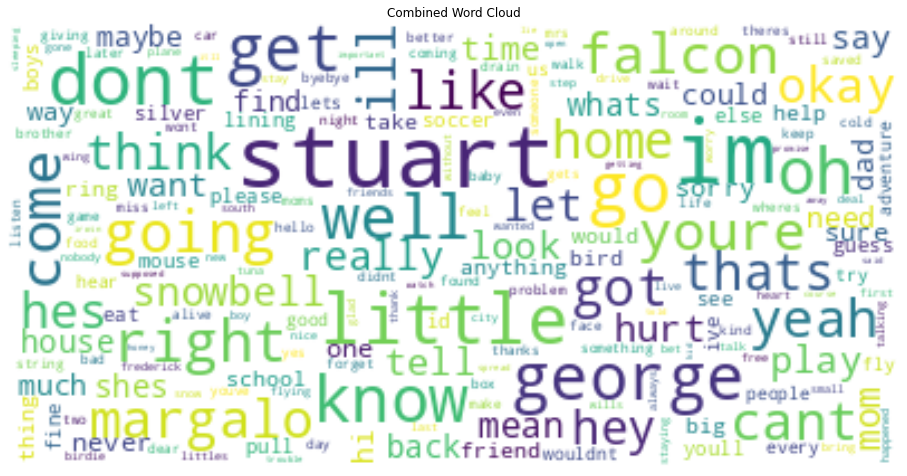

In [90]:
combined_file_text = ""
if not os.path.isdir('output'):
    os.mkdir('output')
for file_path in [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]:
    file_path = join(DATA_PATH, file_path)
    print(file_path)
    file_text = read_file(file_path)
    if INDIVIDUAL_WORD_CLOUDS:
        create_word_cloud(file_text, file_path.split("/")[-1])
    combined_file_text += file_text
print("Combined Word Cloud")
create_word_cloud(combined_file_text, "Combined Word Cloud")